# VAE training and processing

Sample code to train a new VAE and run the CSI processing.

In [1]:
import os
import math
import string
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tensorflow as tf
import tf_keras
import keras
import tensorflow.keras.backend as K

from scipy.stats import dirichlet

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

os.environ["TF_USE_LEGACY_KERAS"]= '1' # Use legacy keras for compatibility

In [2]:
ANTENNAS = 1
antenna = 0  # if ANTENNAS==1, this value selects the antenna ID (from 0 to 3)

BATCH_SIZE = 25
latent_dim = 2
num_activities = 5
folder_name = f'models/single_antenna_{antenna}'

base_directory = './models'
saveGraph = False

In [3]:
random_state = 42
np.random.seed(random_state) # predictable random numbers, for demonstration only
tf.random.set_seed(random_state) # reproducibility

# computes golden ratio for figures
def goldenrect(h):
    return (h * 1.618, h)

def summary_clf(y_test, predicted, y_score, _labels = None):
    print(classification_report(y_test, predicted, labels= _labels))

## CSI data generator

In [4]:
class CsiData(tf_keras.utils.Sequence):
    def __init__(self, csi, labels, indices, batch_size=25, window_size=450, antennas=1):
        self.csi = csi
        self.labels = labels
        self.indices = indices
        self.batch_size = batch_size
        self.window_size = window_size
        self.antennas = antennas

    def __len__(self):
        return int(np.ceil(self.indices.shape[-1] / float(self.batch_size)))

    def __getitem__(self, batch_idx):
        first_idx = batch_idx * self.batch_size
        last_idx = (batch_idx + 1) * self.batch_size
        
        data_batch = [self.csi[x:x + self.window_size, ...] for x in range(first_idx, last_idx)]
        labels_batch = np.transpose([self.labels[first_idx:last_idx]])

        data_batch = tf.convert_to_tensor(data_batch)
        labels_batch = tf.convert_to_tensor(labels_batch)

        if self.antennas == 1:
            data_batch = tf.expand_dims(data_batch, 3)
            labels_batch = tf.expand_dims(labels_batch, 2)

        return data_batch, labels_batch

In [5]:
def load_split_train_test_CSI_data(file_list, num_samples=12000, window_size=450, batch_size=25, antennas=1, random_state=42):
    if antennas == 1:
        train_csi = tf.zeros([0, 2048], dtype=tf.float32)
        test_csi = tf.zeros([0, 2048], dtype=tf.float32)
    else:
        train_csi = tf.zeros([0, 2048, antennas], dtype=tf.float32)
        test_csi = tf.zeros([0, 2048, antennas], dtype=tf.float32)

    train_labels = tf.zeros([0], dtype=tf.int32)
    test_labels = tf.zeros([0], dtype=tf.int32)
    train_indices = tf.zeros([0], dtype=tf.int32)
    test_indices = tf.zeros([0], dtype=tf.int32)

    train_num_samples = math.floor(num_samples * 0.8)
    test_num_samples = num_samples - train_num_samples

    for file in file_list:
        # Load CSI data from MATLAB file
        mat = sio.loadmat(file)      # WARNING This code does not handle exceptions for simplicity...
        data = np.array(mat['csi'])  # ...exceptions would require keeping track of indices
        if antennas == 1:
            data = data[range(num_samples), ..., int(antenna)]
        data = np.round(np.abs(data))
        train_index_offset = train_csi.shape[0]
        test_index_offset = test_csi.shape[0]
        activity_label = file_list.index(file)  # Labels depend on file index 

        train_data, test_data = train_test_split(data, test_size=0.2, random_state=random_state, shuffle=True)
        
        # Cast CSI data into temporary TF tensors for building the dataset
        tmp_train_csi = tf.convert_to_tensor(train_data, dtype=tf.float32)
        tmp_train_labels = tf.convert_to_tensor(activity_label * np.ones(train_num_samples - window_size), dtype=tf.int32)
        tmp_train_indices = tf.convert_to_tensor(tf.range(train_index_offset, train_index_offset + train_num_samples - window_size), dtype=tf.int32)

        # Concatenate to the previous tensors
        train_csi = tf.concat([train_csi, tmp_train_csi], axis=0)
        train_labels = tf.concat([train_labels, tmp_train_labels], axis=0)
        train_indices = tf.concat([train_indices, tmp_train_indices], axis=0)

        # Cast CSI data into temporary TF tensors for building the dataset
        tmp_test_csi = tf.convert_to_tensor(test_data, dtype=tf.float32)
        tmp_test_labels = tf.convert_to_tensor(activity_label * np.ones(test_num_samples - window_size), dtype=tf.int32)
        tmp_test_indices = tf.convert_to_tensor(tf.range(test_index_offset, test_index_offset + test_num_samples - window_size), dtype=tf.int32)

        # Concatenate to the previous tensors
        test_csi = tf.concat([test_csi, tmp_test_csi], axis=0)
        test_labels = tf.concat([test_labels, tmp_test_labels], axis=0)
        test_indices = tf.concat([test_indices, tmp_test_indices], axis=0)
        
    # Normalize the CSI dataset
    if antennas == 1:
        train_csi = tf.math.divide(train_csi, tf.math.reduce_max(train_csi, axis=(0, 1)))
        test_csi = tf.math.divide(test_csi, tf.math.reduce_max(test_csi, axis=(0, 1)))
    else:
        train_csi = tf.math.divide(train_csi, tf.math.reduce_max(train_csi, axis=(0, 1, 2)))
        test_csi = tf.math.divide(test_csi, tf.math.reduce_max(test_csi, axis=(0, 1, 2)))

    train_data = CsiData(train_csi, train_labels, train_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)
    test_data = CsiData(test_csi, test_labels, test_indices, batch_size=batch_size, window_size=window_size, antennas=antennas)

    return train_data, test_data

## Variational Auto-Encoder

In [6]:
class Sampling(tf_keras.layers.Layer):
    """Takes a couple (z_mean, z_log_var) to draw a sample z from the latent space."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf_keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon
    
def create_csi_encoder(input_shape, latent_dim):
    encoder_inputs = tf_keras.Input(shape=input_shape)
    x = tf_keras.layers.Conv2D(32, (5, 8), activation='relu', strides=(5, 8), padding='valid')(encoder_inputs)
    x = tf_keras.layers.Conv2D(32, (5, 8), activation='relu', strides=(5, 8), padding='valid')(x)
    x = tf_keras.layers.Conv2D(32, (2, 4), activation='relu', strides=(2, 4), padding='valid')(x)
    x = tf_keras.layers.Flatten()(x)
    x = tf_keras.layers.Dense(16, activation='relu')(x)

    z_mean = tf_keras.layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = tf_keras.layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])

    return tf_keras.Model(encoder_inputs, [z_mean, z_log_var, z], name='encoder')


def create_csi_decoder(input_shape, latent_dim, out_filter):
    decoder_inputs = tf_keras.Input(shape=(latent_dim,))
    x = tf_keras.layers.Dense(math.prod(input_shape), activation='relu')(decoder_inputs)
    x = tf_keras.layers.Reshape(input_shape)(x)
    x = tf_keras.layers.Conv2DTranspose(32, (2, 4), activation='relu', strides=(2, 4), padding='same')(x)
    x = tf_keras.layers.Conv2DTranspose(32, (5, 8), activation='relu', strides=(5, 8), padding='same')(x)
    x = tf_keras.layers.Conv2DTranspose(32, (5, 8), activation='relu', strides=(5, 8), padding='same')(x)
    decoder_outputs = tf_keras.layers.Conv2DTranspose(out_filter, out_filter, activation='sigmoid', padding='same')(x)

    return tf_keras.Model(decoder_inputs, decoder_outputs, name='decoder')

In [7]:
class VAE(tf_keras.Model):
    def __init__(self, enc_input_shape=(450, 2048, 1), dec_input_shape=(9, 8, 32), latent_dim=2, **kwargs):
        super().__init__(**kwargs)
        self.encoder = create_csi_encoder(enc_input_shape, latent_dim)
        self.decoder = create_csi_decoder(dec_input_shape, latent_dim, enc_input_shape[-1])
        self.total_loss_tracker = tf_keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tf_keras.metrics.Mean(name='reconstruction_loss')
        self.kl_loss_tracker = tf_keras.metrics.Mean(name='kl_loss')

        self.encoder.summary()
        self.decoder.summary()

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data[0])
            reconstruction = self.decoder(z)

            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    tf_keras.losses.binary_crossentropy(data[0], reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            'loss': self.total_loss_tracker.result(),
            'reconstruction_loss': self.reconstruction_loss_tracker.result(),
            'kl_loss': self.kl_loss_tracker.result(),
        }

    def call(self, inputs, training=None, mask=None):
        pass


In [8]:
def apply_vae_encoder(vae, source):
    #Use the VAE to process CSI data
    z_data = np.zeros([0, 4])
    z_labels = np.zeros([0])

    for (data, labels) in source:
        labels = tf.squeeze(labels)
        z_mean, z_log_var, _ = vae.encoder.predict(data, verbose=0)
        z_tmp = np.concatenate([z_mean, z_log_var], axis=1)
        z_data = np.concatenate([z_data, z_tmp], axis=0)
        z_labels = np.concatenate([z_labels, labels.numpy().ravel()], axis=0)
        
    return z_data, z_labels

In [9]:
checkpoint_path = f'./{folder_name}/' + 'cp-{epoch:04d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)
checkpoint_cb = tf_keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stopping_cb = tf_keras.callbacks.EarlyStopping(monitor='loss', patience=3)
csv_logger_cb = tf_keras.callbacks.CSVLogger(f'./{folder_name}/model_history_log.csv', append=True)

## Data Processing

### PCA Compression

In [10]:
def find_n_components(data, target, directory=base_directory, saveGraph=False, plotGraph=True):
    os.makedirs(directory, exist_ok=True)
    #Apply PCA
    pca = PCA()
    pca.fit(data)

    var_cumulative = np.cumsum(pca.explained_variance_ratio_)*100

    #finds PCs that explain 95% of the variance
    num_components = np.argmax(var_cumulative > target) + 1
    print(f"Number of components explaining {target}% variance: "+ str(num_components))

    if plotGraph:
        plt.figure(figsize=(10, 5))
        plt.title('Cumulative Explained Variance explained by the components')
        plt.ylabel('Cumulative Explained variance')
        plt.xlabel('Principal components')
        plt.axvline(x=num_components, color="r", linestyle="--")
        plt.axhline(y=target, color="r", linestyle="--")
        plt.plot(range(1, pca.n_components_ + 1), var_cumulative, marker='o', linestyle='--')
        plt.grid()
        if (saveGraph):
            graph_path = os.path.join(directory, 'var_cumulative_x_component.png')
            plt.savefig(graph_path)
            print("Graph saved in: ", graph_path)
        plt.show()

    return num_components

def analyze_PCA(data, n_components, directory=base_directory, saveGraph=False, plotGraph=True):
    os.makedirs(directory, exist_ok=True)
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(data)

    reduced_df = pd.DataFrame(data=reduced_data, columns=[f'PC{i}' for i in range(n_components)])

    #Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:", explained_variance_ratio)

    #Cumulative explained variance
    cumulative_explained_variance = np.cumsum(explained_variance_ratio)
    print("Final Cumulative Explained Variance:", cumulative_explained_variance[-1])

    if (plotGraph):
        plt.figure(figsize=(10, 5))
        plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
        plt.title('Cumulative Explained Variance by PCA Components')
        plt.xlabel('Number of Principal Components')
        plt.ylabel('Cumulative Explained Variance')
        plt.grid()
        if (saveGraph):
            graph_path = os.path.join(directory, 'cumulative_explained_variance.png')
            plt.savefig(graph_path)
            print("Graph saved in: ", graph_path)
        plt.show()
    
    return reduced_df, pca

def reconstruct_data(df, pca, columns):
    df_reconstructed = pca.inverse_transform(df.values)
    df_reconstructed = pd.DataFrame(df_reconstructed, columns=columns)    
    return df_reconstructed

### Quantization

In [11]:
def lloyd_max_quantization(data, num_levels=16, max_iter=100, delta=1e-6):
    min_val = np.min(data)
    max_val = np.max(data)
    clusters = np.linspace(min_val, max_val, num_levels) #Uniformly spaced 

    for _ in range(max_iter):
        thresholds = (clusters[:-1] + clusters[1:]) / 2 #Defines intervals of clusters
        indices = np.digitize(data, thresholds) #Assign each data point to a cluster
        
        new_clusters = np.array([data[indices == i].mean() for i in range(num_levels)]) #Update clusters to better represent the data
        
        empty_clusters = np.isnan(new_clusters) #Restore previous cluster if empty
        new_clusters[empty_clusters] = clusters[empty_clusters] 

        #stop if changes between iterations are small
        if np.max(np.abs(new_clusters - clusters)) < delta:
            break

        clusters = new_clusters

    #Quantize the data based on the final clusters
    quantized_data = clusters[indices]

    return quantized_data, clusters, thresholds

def dequantize_lloyd_max(quantized_data, clusters, thresholds):
    indices = np.digitize(quantized_data, thresholds, right=True)
    return clusters[indices]

def apply_quantization(reduced_df, lvls):
    df_quantized = reduced_df.apply(lambda col: lloyd_max_quantization(col.values, num_levels=lvls)[0])
    return df_quantized

### Metrics

In [12]:
def compute_bits_needed(source, verbose=True):
    data = source.copy()
    window_size = 450
    bits_needed_window = {}
    total_bits = 0
    total_symbols = 0
    
    for index in range(0, len(data), window_size):
        bits_needed = {}
        data_window = data.iloc[index : index + window_size] 
        window_total_bits = 0
        window_total_symbols = 0
        
        for col in data_window.columns:
            num_symbols = len(data_window[col].unique())
            total_num_symbols = len(data_window[col])
            
            if num_symbols > 1:
                bits_needed[col] = np.ceil(np.log2(num_symbols)).astype(int)  # Number of bits to represent each symbol
            else:
                bits_needed[col] = 1  # If only one unique symbol
            if verbose: print(f"Column: {col}, Bits needed: {bits_needed[col]} bits")
            
            # bits this column in the window
            column_bits = bits_needed[col] * total_num_symbols
            window_total_bits += column_bits
            window_total_symbols += total_num_symbols

        bits_needed_window[index] = window_total_bits
        if verbose: print(f"Window: {index}, Average bits needed: {window_total_bits:.2f} bits")
    
        total_bits += window_total_bits
        total_symbols += window_total_symbols

    average_bits_per_symbol = total_bits / total_symbols if total_symbols > 0 else 0
    average_bits_per_window = np.mean(list(bits_needed_window.values())).round(2)

    #print(f"\nGlobal metrics:")
    print(f"Average bits per symbol: {average_bits_per_symbol:.2f} bits")
    print(f"Average bits per window: {average_bits_per_window:.2f} bits")
    print(f"Bits for the whole dataset: {total_bits:.2f} bits")

    return average_bits_per_symbol.round(2), average_bits_per_window, total_bits

In [13]:
def bits_needed(source, num_lvls=-1):
    data = source.copy()
    window_size = 450
    num_features = len(data.columns)
    bits_needed_unique = {}
    avg_bits_needed = {}
    bits_needed_window = {}
    total_bits_needed_dataset = 0

    for index in range(0, len(data), window_size):
        data_window = data.iloc[index : index + window_size] 
        for col in data_window.columns:
            num_symbols = len(data_window[col].unique())
            if num_lvls > 0:
                bits_needed_unique[col] = np.ceil(np.log2(num_lvls)).astype(int)
                #print(f"Column: {col}, Bits needed: {bits_needed_unique[col]} bits (num levels: {num_lvls})")
            else:
                bits_needed_unique[col] = np.ceil(np.log2(num_symbols)).astype(int)
                
        avg_bits_needed[index] = np.mean(list(bits_needed_unique.values())).round(2)
        bits_needed_window[index] = sum(bits_needed_unique.values())
        total_bits_needed_dataset += sum(bits_needed_unique.values())

    bits_needed = np.mean(list(avg_bits_needed.values())).round(2)
    bits_needed_window = np.mean(list(bits_needed_window.values())).round(2)

    return bits_needed, bits_needed_window, total_bits_needed_dataset

## MLP

### Load dataset

The VAE has been trained without any information about the target classes; it just tries to minimize reconstruction loss + KL loss.

The Encoder in the VAE maps sequences of CSI into **2 Gaussian variables** with parameters (z_mean, z_log_var).

More in detail, from the dataset we load `data` and `labels`.
- `data`: every element is a 4-tuple with the values (z1_mean, z2_mean, z1_log_var, z2_log_var)
- `labels`: 5 different classes, labelled with integers from 0 to 4 (0 = walk, 1 = run, 2 = jump, 3 = sit, 4 = empty)

Available datasets:
- `single_antenna`: data of just antenna 1, normalized wrt to the maximum value over the entire dataset (four antennas are available, numbered from 0 to 3)
- `four_antennas`: data of the four antennas fused together, normalized wrt to the maximum value over the entire dataset
- `four_antennas_latent_space_3`: same as `four_antennas`, but the CSI is mapped onto 3 Gaussian variables; hence, every element in `data` is a 6-tuple with the values (z1_mean, z2_mean, z3_mean, z1_log_var, z2_log_var, z3_log_var)

In [14]:
semantic_classes = ["Walk", "Run", "Jump", "Sit", "Empty"]
base_directory = './results'
os.makedirs(base_directory, exist_ok=True)

In [15]:
def load_experiment(directory, scaler=None):
    data = None
    labels = None
    
    # features columns
    fcolumns = ['mu1','mu2','sigma1','sigma2']
    
    # check which experiments we wants to load
    with open(directory, 'rb') as f:
        data, labels = pickle.load(f)

    # labels are categoricals
    labels = np.asarray(labels, dtype=np.int32)
    
    # let's load into a dataframe
    df = pd.DataFrame(data, columns=fcolumns)
    df['signal'] = labels
    
    if scaler is None:
        # Fit scaler on training data
        scaler = StandardScaler().fit(df[fcolumns])
    df[fcolumns] = scaler.transform(df[fcolumns])
    
    X = df[fcolumns]
    y = df['signal']

    # one-hot-encoding
    y_dummy = keras.utils.to_categorical(y)
    
    return X, y, y_dummy, scaler, fcolumns

## EDL

In [16]:
num_epochs_annealing = 1
num_classes = 5

ep = 1.0
class GetEpochs(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        global ep
        ep += 1

def res_to_mean(ev, dim = 5):
    return np.max(dirichlet.mean(ev.reshape(dim,)+1))

def res_to_dirichlet(ev):
    alpha = ev.reshape(2,)+1
    S = np.sum(alpha)
    K = 2.0
    return dirichlet.mean(alpha), K/S

def edl_accuracy(yTrue, yPred):
    pred = K.argmax(yPred, axis=1)
    truth = K.argmax(yTrue, axis=1)
    match = K.reshape(K.cast(K.equal(pred, truth), "float32"),(-1,1))
    return K.mean(match)

def load_edl_experiment(name):
    keras.models.load_model(name)

def plot_res_beta(ev):
    alpha = ev.reshape(2,)+1
    plt.figure(figsize=(16,9))
    x = np.linspace(0,1,1000)
    plt.plot(x, beta.pdf(x, alpha[1], alpha[0]))
    x1, x2 = beta.interval(0.95, alpha[1], alpha[0])
    areaplot = np.multiply(beta.pdf(x, alpha[1],alpha[0]), rect(x,x1, x2))
    plt.fill_between(x, 0, areaplot, alpha=0.5)

def results_test(num_components, num_levels, train_dir, test_dir):
    X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dir)
    X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dir, scaler)
    model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    
    mlp_edl = keras.models.load_model(model_directory, compile=False)
    mlp_edl_scores = np.array([res_to_mean(r, dim=5) for r in mlp_edl.predict(X_test)])
    y_predictions_edl = np.array(tf.argmax(mlp_edl.predict(X_test), axis=1))

    print(summary_clf(y_test, y_predictions_edl, mlp_edl_scores))
    accuracy = accuracy_score(y_test, y_predictions_edl)

    cm = confusion_matrix(y_test, y_predictions_edl)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=semantic_classes)
    cmdisp = disp.plot(cmap="cividis")
    CM_directory = os.path.join(base_directory, f'{num_components}_components/CMs/{num_components}components_{num_levels}lvls_ConfusionMatrix.png')
    os.makedirs(os.path.dirname(CM_directory), exist_ok=True)
    cmdisp.figure_.savefig(CM_directory, bbox_inches='tight')

    return round(accuracy, 5)

In [17]:
def run_edl_experiment(name, num_components, num_levels, _X_train, _y_train_dummy):

    model_edl = None
    num_classes = 5
    
    if name == "Delayed-Fusing":
        num_epochs_annealing = 3
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(16, activation='relu', input_shape=(16,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5, activation='softplus'))

    elif name == "Early-Fusing":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.001
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(4,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    elif name == "Early-Fusing3":
        num_epochs_annealing = 22
        batch_size = 128
        lr = 0.01
        epochs = 50
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(8, activation='relu', input_shape=(6,)))
        model_edl.add(tf.keras.layers.Dense(8, activation='relu'))
        model_edl.add(tf.keras.layers.Dense(units=5,activation='softplus'))

    else:
        num_epochs_annealing = 22
        batch_size = 64
        lr = 0.0001
        epochs = 100
        model_edl = tf.keras.models.Sequential()
        model_edl.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model_edl.add(tf.keras.layers.Dropout(0.5))
        model_edl.add(tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model_edl.add(tf.keras.layers.Dropout(0.5))
        model_edl.add(tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
        model_edl.add(tf.keras.layers.Dense(5, activation='softmax'))

    def KL(alpha):
        beta=K.constant(np.ones((1,num_classes)),dtype="float32")
        S_alpha = K.sum(alpha,axis=1,keepdims=True)
        S_beta = K.sum(beta,axis=1,keepdims=True)
        lnB = tf.math.lgamma(S_alpha) - K.sum(tf.math.lgamma(alpha),axis=1,keepdims=True)
        lnB_uni = K.sum(tf.math.lgamma(beta),axis=1,keepdims=True) - tf.math.lgamma(S_beta)

        dg0 = tf.math.digamma(S_alpha)
        dg1 = tf.math.digamma(alpha)

        return K.sum((alpha - beta)*(dg1-dg0),axis=1,keepdims=True) + lnB + lnB_uni

    # Loss function considering the expected squared error and the KL divergence
    def mse_loss(yTrue,yPred):
        alpha = yPred + 1
        S = K.sum(alpha, axis=1, keepdims=True)
        m = alpha / S

        # A + B minimises the sum of squared loss, see discussion in EDL paper for the derivation
        A = K.sum((yTrue-m)**2, axis=1, keepdims=True)
        B = K.sum(alpha*(S-alpha)/(S*S*(S+1)), axis=1, keepdims=True)

        # the lambda_t parameter, in this case min{1, t/10} with t the number of epochs
        ll = min(1.0, float(ep/float(num_epochs_annealing)))
        
        alp = yPred*(1-yTrue) + 1 
        C =  ll * KL(alp)

        return A + B + C

    optimizer = keras.optimizers.Adam(learning_rate=lr)
    model_edl.compile(loss=mse_loss, optimizer=optimizer, metrics=[edl_accuracy])

    model_edl.fit(_X_train, _y_train_dummy,
      batch_size=batch_size,
      epochs=epochs,
      verbose=1,
      shuffle=False)

    model_directory = os.path.join(base_directory, f'{num_components}_components/models/{num_components}components_{num_levels}lvls_Keras_Model.keras')
    os.makedirs(os.path.dirname(model_directory), exist_ok=True)
    model_edl.save(model_directory)


## Run

## Iterative Runs

In [ ]:
components = list(range(1, 11)) + list(range(15, 41, 5)) + list(range(50, 101, 10))
levels = [2**i for i in range(1, 8)]

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_generator = CsiDataGenerator(file_list, batch_size=BATCH_SIZE, antenna_select=antenna)

csi_data = csi_generator.csi.numpy()
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

df_csi_data_original = pd.DataFrame(csi_data, columns=csi_subcarriers)

In [ ]:
for num_components in components:
    print(f"-------------- {num_components} components --------------")
    directory = f'./results/{num_components}_components/dumps'
    os.makedirs(directory, exist_ok=True)
    df_csi_data = df_csi_data_original.copy()
    #Apply PCA
    
    df_reduced, pca = analyze_PCA(df_csi_data, num_components, directory=directory, saveGraph=True, plotGraph=True)

    for num_levels in levels:
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        #Quantize the data
        df_train_quantized = apply_quantization(df_reduced, num_levels)

        #Reconstruct the data
        df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)
        df_train_reconstructed = df_train_reconstructed.to_numpy()
        reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed)
        csi_generator.csi = reconstructed_train_data

        #Use the VAE to process CSI data
        z_data = np.zeros([0, 4])
        z_labels = np.zeros([0])

        vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
        vae.compile(optimizer=keras.optimizers.Adam())
        vae.load_weights(f'./{folder_name}/weights_vae').expect_partial()

        for (data, labels) in csi_generator:
            labels = tf.squeeze(labels)
            z_mean, z_log_var, _ = vae.encoder.predict(data, verbose=0)
            z_tmp = np.concatenate([z_mean, z_log_var], axis=1)
            z_data = np.concatenate([z_data, z_tmp], axis=0)
            z_labels = np.concatenate([z_labels, labels], axis=0)

        # Store the latent space representation of CSI data to file.
        sub_dir=os.path.join(directory, f'{num_components}components_{num_levels}lvls_single_antenna_{antenna}.pkl')
        with open(sub_dir, 'wb') as f:
            pickle.dump([z_data, z_labels], f)

In [ ]:
results = []

for num_components in components:
    for num_levels in levels:
        print(f"------------------------- Running experiment for {num_components} components with {num_levels} levels -------------------------")
        dump_directory =  os.path.join(base_directory, f'{num_components}_components/dumps/{num_components}components_{num_levels}lvls_single_antenna_{antenna}.pkl')
        
        # Load data
        X_train, X_test, y_train, y_test, y_train_dummy, y_test_dummy, scaler, df, fcolumns = load_experiment_reconstructed(dump_directory)
        
        # Run model
        name = "No-Fused-1"
        run_edl_experiment(name, num_components, num_levels, X_train, y_train_dummy)

        # Test model
        accuracy = results_test(num_components, num_levels, dump_directory)
        results.append(
            {
                "num_components": num_components,
                "num_levels": num_levels,
                "accuracy": accuracy
            })
        

results_df = pd.DataFrame(results)
results_df.to_csv('results_csv/results2.csv', index=False)

In [ ]:
df_accuracy = pd.read_csv('results_csv/results.csv')
df_bits = pd.read_csv('results_csv/bit_results_single_antenna_0.csv')
df_VAE_accuracy = pd.read_csv('results_csv/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/VAE_bit_results_single_antenna_0.csv')

df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
components = [1, 2, 3, 4, 10]
#components = [30, 35, 40, 50, 60, 70, 80, 90, 100]

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    #if num_components not in components:
    #    continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_acc_bit['QT_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE', linewidth=3)
plt.axhline(y=0.95, color="r", linestyle=":", label="max accuracy")
plt.title('Accuracy and Bits Comparison (quantized data)')
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig(os.path.join('accuracy_bit_comparison[BxS][1-100].png'))
plt.show()

In [ ]:
df_accuracy = pd.read_csv('results_csv/results.csv')
df_bits = pd.read_csv('results_csv/bit_results_single_antenna_0.csv')
df_VAE_accuracy = pd.read_csv('results_csv/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/VAE_bit_results_single_antenna_0.csv')

df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
components = [1, 2, 3, 4, 10]
#components = [30, 35, 40, 50, 60, 70, 80, 90, 100]

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_win_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_acc_bit['QT_win_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE')
plt.axhline(y=0.95, color="r", linestyle=":", label="max accuracy")
plt.title('Accuracy and Bits Comparison (quantized data)')
plt.xlabel('Average bits per window')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.savefig(os.path.join('accuracy_bit_comparison[BxW][1-100].png'))
plt.show()

## Bit Metrics

In [ ]:
components = list(range(1, 11)) + list(range(15, 41, 5))
components = (range(50, 101, 10))
levels = [2**i for i in range(1, 8)]
bit_results = []

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_generator = CsiDataGenerator(file_list, batch_size=BATCH_SIZE, antenna_select=antenna)

csi_data = csi_generator.csi.numpy()
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

df_csi_data_original = pd.DataFrame(csi_data, columns=csi_subcarriers)

OG_bits, OG_win_bits,total_OG_bits = bits_needed(df_csi_data_original)
print(f"Bits needed: {OG_bits} bits")
print(f"AvgBits needed per window: {OG_win_bits} bits")
print(f"Total Bits needed: {total_OG_bits} bits")

for num_components in components:
    print(f"-------------- {num_components} components ----------------------")
    directory = f'./results/{num_components}_components/dumps'
    os.makedirs(directory, exist_ok=True)
    df_csi_data = df_csi_data_original.copy()

    #Apply PCA
    df_reduced, pca = analyze_PCA(df_csi_data, num_components, directory=directory, plotGraph=False)
    
    print (f"DF_CSI_DATA")
    #PCA_avg_bits_per_symbol, PCA_avg_bits_per_window, PCA_total_bits = compute_bits_needed(df_reduced, verbose=False)
    PCA_bits, PCA_win_bits,total_PCA_bits = bits_needed(df_reduced)
    print(f"Bits needed: {PCA_bits} bits")
    print(f"AvgBits needed per window: {PCA_win_bits} bits")
    print(f"Total Bits needed: {total_PCA_bits} bits")

    for num_levels in levels:
        print(f"-------------- {num_components} components {num_levels} lvls --------------")
        #Quantize the data
        df_train_quantized = apply_quantization(df_reduced, num_levels)
        print (f"DF_QUANTIZED")
        #QT_avg_bits_per_symbol, QT_avg_bits_per_window, QT_total_bits = compute_bits_needed(df_quantized, verbose=False)
        QT_bits, QT_win_bits, total_QT_bits = bits_needed(df_train_quantized, num_levels)
        print(f"Bits needed: {QT_bits} bits")
        print(f"AvgBits needed per window: {QT_win_bits} bits")
        print(f"Total Bits needed: {total_QT_bits} bits")

        #Reconstruct the data
        df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)
        print (f"DF_RECONSTRUCTED")
        #REC_avg_bits_per_symbol, REC_avg_bits_per_window, REC_total_bits = compute_bits_needed(df_reconstructed, verbose=False)
        REC_bits, REC_win_bits, total_REC_bits = bits_needed(df_train_reconstructed)
        print(f"Bits needed: {REC_bits} bits")
        print(f"AvgBits needed per window: {REC_win_bits} bits")
        print(f"Total Bits needed: {total_REC_bits} bits")
        
        df_train_reconstructed = df_train_reconstructed.to_numpy()
        reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed)
        csi_generator.csi = reconstructed_train_data

        bit_results.append({
            'num_components': num_components,
            'num_levels': num_levels,
            'OG_bits': OG_bits,
            'PCA_bits': PCA_bits,
            'QT_bits': QT_bits,
            'REC_bits': REC_bits,
            'OG_win_bits': OG_win_bits,
            'PCA_win_bits': PCA_win_bits,
            'QT_win_bits': QT_win_bits,
            'REC_win_bits': REC_win_bits,
            'total_OG_bits': total_OG_bits,
            'total_PCA_bits': total_PCA_bits,
            'total_QT_bits': total_QT_bits,
            'total_REC_bits': total_REC_bits
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results_csv/bit_results_single_antenna2_{antenna}.csv', index=False)

## VAE Output Quantized

In [62]:
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_generator = CsiDataGenerator(file_list, batch_size=BATCH_SIZE, antenna_select=antenna)

In [ ]:
#Use the VAE to process CSI data
z_data = np.zeros([0, 4])
z_labels = np.zeros([0])

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/weights_vae').expect_partial()

for (data, labels) in csi_generator:
    labels = tf.squeeze(labels)
    z_mean, z_log_var, _ = vae.encoder.predict(data, verbose=0)
    z_tmp = np.concatenate([z_mean, z_log_var], axis=1)
    z_data = np.concatenate([z_data, z_tmp], axis=0)
    z_labels = np.concatenate([z_labels, labels], axis=0)

In [ ]:
directory = f'./results/0_components/dumps'
bit_results = []

df_z_data = pd.DataFrame(z_data, columns=[f'z_mean_{i}' for i in range(2)] + [f'z_log_var_{i}' for i in range(2)])

for lvl in levels:
    print(f"-------------- {lvl} lvls --------------")
    sub_dir=os.path.join(directory, f'{lvl}lvls_single_antenna_{antenna}.pkl')

    df_train_quantized = apply_quantization(df_z_data, lvl)
    print (f"DF_QUANTIZED")
        #QT_avg_bits_per_symbol, QT_avg_bits_per_window, QT_total_bits = compute_bits_needed(df_quantized, verbose=False)
    QT_bits, QT_win_bits, total_QT_bits = bits_needed(df_train_quantized, lvl)
    print(f"Bits needed: {QT_bits} bits")
    print(f"AvgBits needed per window: {QT_win_bits} bits")
    print(f"Total Bits needed: {total_QT_bits} bits")

    z_data = df_train_quantized.to_numpy()

#    with open(sub_dir, 'wb') as f:
#       pickle.dump([z_data, z_labels], f)

    bit_results.append({
            'num_levels': lvl,
            'QT_bits': QT_bits,
            'QT_win_bits': QT_win_bits,
            'total_QT_bits': total_QT_bits,
        })

bit_results = pd.DataFrame(bit_results)
bit_results.to_csv(f'./results/csv/VAE_bit_results_single_antenna_{antenna}.csv', index=False)

## Single Run

In [ ]:
file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
csi_generator = CsiDataGenerator(file_list, batch_size=BATCH_SIZE, antenna_select=antenna)

target = 90
num_levels = 8

In [ ]:
csi_data = csi_generator.csi.numpy()
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

df_csi_data = pd.DataFrame(csi_data, columns=csi_subcarriers)

In [ ]:
num_components = find_n_components(df_csi_data, target, plotGraph=False)
df_reduced, pca = analyze_PCA(df_csi_data, num_components, plotGraph=False)

In [ ]:
df_train_quantized = apply_quantization(df_reduced, num_levels)

In [ ]:
df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)

df_train_reconstructed = df_train_reconstructed.to_numpy()
reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed)

print('Original csi data shape:', df_csi_data.shape)
print('PCA df shape:', df_reduced.shape)
print('Reconstructed csi data shape:', reconstructed_train_data.shape)

csi_generator.csi = reconstructed_train_data

In [ ]:
#Use the VAE to process CSI data
z_data = np.zeros([0, 4])
z_labels = np.zeros([0])

vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
vae.compile(optimizer=keras.optimizers.Adam())
vae.load_weights(f'./{folder_name}/weights_vae').expect_partial()

for (data, labels) in csi_generator:
    labels = tf.squeeze(labels)
    z_mean, z_log_var, _ = vae.encoder.predict(data, verbose=0)
    z_tmp = np.concatenate([z_mean, z_log_var], axis=1)
    z_data = np.concatenate([z_data, z_tmp], axis=0)
    z_labels = np.concatenate([z_labels, labels], axis=0)

In [ ]:
with open(f'single_antenna_{antenna}', 'wb') as f:
    pickle.dump([z_data, z_labels], f)

## New Comprehenisve Run

In [18]:
components = list(range(1, 11)) + list(range(15, 41, 5)) + list(range(50, 101, 10))
components = [1, 2, 3, 4, 10, 20, 30, 40, 50, 100]
levels = [2**i for i in range(1, 8)]
csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]

train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)


In [ ]:
results = []
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

for num_components in components:
    print(f"-------------- {num_components} components --------------")
    df_train = df_csi_train.copy()
    df_test = df_csi_test.copy()
    directory = f'./dumps/{num_components}_components'
    os.makedirs(directory, exist_ok=True)

    #Apply PCA
    df_train_reduced, pca = analyze_PCA(df_train, num_components, directory=directory, saveGraph=True, plotGraph=True)

    test_reduced = pca.transform(df_test)
    df_test_reduced = pd.DataFrame(test_reduced, columns=[f'PC{i}' for i in range(num_components)])

    for num_levels in levels:
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        filename = f'{num_levels}lvls_single_antenna_{antenna}'
        #Quantize the data
        df_train_quantized = apply_quantization(df_train_reduced, num_levels)
        df_test_quantized = apply_quantization(df_test_reduced, num_levels)

        #Reconstruct the data
        df_train_reconstructed = reconstruct_data(df_train_quantized, pca, csi_subcarriers)
        df_train_reconstructed = df_train_reconstructed.to_numpy()
        reconstructed_train_data = tf.convert_to_tensor(df_train_reconstructed, dtype=tf.float32)
        train_data.csi = reconstructed_train_data

        df_test_reconstructed = reconstruct_data(df_test_quantized, pca, csi_subcarriers)
        df_test_reconstructed = df_test_reconstructed.to_numpy()
        reconstructed_test_data = tf.convert_to_tensor(df_test_reconstructed, dtype=tf.float32)
        test_data.csi = reconstructed_test_data

        vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
        vae.compile(optimizer=tf_keras.optimizers.Adam())
        vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()
        
        print("Encoding train data...")
        z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
        
        print("Encoding test data...")
        z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

        train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
        os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
        test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
        os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
        print("Saving data...")
        with open(train_dump_dir, 'wb') as f:
            pickle.dump([z_data_train, z_labels_train], f)
        with open(test_dump_dir, 'wb') as f:
            pickle.dump([z_data_test, z_labels_test], f)

print("Done")

       

In [ ]:
for num_components in components:
    directory = f'./dumps/{num_components}_components'
    for num_levels in levels:  
        print(f"-------------- {num_components} components w/ {num_levels} lvls --------------")
        train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
        test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')

        X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
        X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler)

        name = "No-Fused-1"
        run_edl_experiment(name, num_components, num_levels, X_train, y_train_dummy)

        # Test model
        accuracy = results_test(num_components, num_levels, train_dump_dir, test_dump_dir)
        results.append(
            {
                "num_components": num_components,
                "num_levels": num_levels,
                "accuracy": accuracy
            })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/results.csv', index=False)

In [ ]:
df_accuracy = pd.read_csv('results_csv/results.csv')
df_bits = pd.read_csv('results_csv/bit_results_single_antenna_0.csv')
df_VAE_accuracy = pd.read_csv('results_csv/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/VAE_bit_results_single_antenna_0.csv')

df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
components = [1, 2, 3, 4, 10]
#components = [30, 35, 40, 50, 60, 70, 80, 90, 100]

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    #if num_components not in components:
    #    continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_acc_bit['QT_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE', linewidth=3)
plt.axhline(y=0.95, color="r", linestyle=":", label="max accuracy")
plt.title('Accuracy and Bits Comparison (quantized data)')
plt.xlabel('Bits per symbol')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(os.path.join('accuracy_bit_comparison[BxS][1-100].png'))
plt.show()

In [ ]:
df_accuracy = pd.read_csv('results_csv/results.csv')
df_bits = pd.read_csv('results_csv/bit_results_single_antenna_0.csv')
df_VAE_accuracy = pd.read_csv('results_csv/VAE_results.csv')
df_VAE_bits = pd.read_csv('results_csv/VAE_bit_results_single_antenna_0.csv')

df_acc_bit = pd.merge(df_accuracy, df_bits, on=['num_components', 'num_levels'])
df_VAE_acc_bit = pd.merge(df_VAE_accuracy, df_VAE_bits, on=['num_levels'])

#components = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25]
components = [1, 2, 3, 4, 10]
#components = [30, 35, 40, 50, 60, 70, 80, 90, 100]

plt.figure(figsize=(20, 10))
for num_components in df_acc_bit['num_components'].unique():
    if num_components not in components:
        continue
    target_data = df_acc_bit[df_acc_bit['num_components'] == num_components]
    plt.plot(target_data['QT_win_bits'], target_data['accuracy'], marker='o', linestyle='--', label=f'{num_components} components')
plt.plot(df_VAE_acc_bit['QT_win_bits'], df_VAE_acc_bit['accuracy'], marker='o', label='Post VAE')
plt.axhline(y=0.95, color="r", linestyle=":", label="max accuracy")
plt.title('Accuracy and Bits Comparison (quantized data)')
plt.xlabel('Average bits per window')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
#plt.savefig(os.path.join('accuracy_bit_comparison[BxW][1-100].png'))
plt.show()

## Tests

In [18]:
levels = [2**i for i in range(1, 8)]
levels = [8]

file_list = [f'./dataset/S1a_{x}.mat' for x in string.ascii_uppercase[:num_activities]]
train_data, test_data = load_split_train_test_CSI_data(file_list, batch_size=BATCH_SIZE, antennas=ANTENNAS)

csi_subcarriers = [f"Ampl_{i}" for i in range(1024)] + [f"Ampl_{-i}" for i in range(1, 1025)]
df_csi_train = pd.DataFrame(train_data.csi.numpy(), columns=csi_subcarriers)
df_csi_test = pd.DataFrame(test_data.csi.numpy(), columns=csi_subcarriers)

In [ ]:
load_pretrained_models = True

if load_pretrained_models:
    print('Loading pretrained models...')
    """!wget https://zenodo.org/record/7983057/files/VAE_models.zip
    !unzip -o VAE_models.zip
    !rm VAE_models.zip"""
else:
    # Train from scratch
    #!mkdir {folder_name}
    vae = VAE()
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.save_weights(checkpoint_path.format(epoch=0))
    vae.fit(train_data, epochs=20, shuffle=True,
            callbacks=[checkpoint_cb, early_stopping_cb, csv_logger_cb])
    vae.save_weights(f'./{folder_name}/train_weights_vae')

In [ ]:
results = []
folder_name = f'models/single_antenna_{antenna}'

print(f"-------------- 0 components --------------")
directory = './dumps/0_components'
os.makedirs(directory, exist_ok=True)

for num_levels in levels:
    print(f"-------------- 0 components w/ {num_levels} lvls --------------")
    filename = f'{num_levels}lvls_single_antenna_{antenna}'

    vae = VAE(enc_input_shape=(450, 2048, ANTENNAS))
    vae.compile(optimizer=tf_keras.optimizers.Adam())
    vae.load_weights(f'./{folder_name}/train_weights_vae').expect_partial()
    
    print("Encoding train data...")
    z_data_train, z_labels_train = apply_vae_encoder(vae, train_data)
    
    print("Encoding test data...")
    z_data_test, z_labels_test = apply_vae_encoder(vae, test_data)

    train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
    os.makedirs(os.path.dirname(train_dump_dir), exist_ok=True)
    test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
    os.makedirs(os.path.dirname(test_dump_dir), exist_ok=True)
    with open(train_dump_dir, 'wb') as f:
        pickle.dump([z_data_train, z_labels_train], f)
    with open(test_dump_dir, 'wb') as f:
        pickle.dump([z_data_test, z_labels_test], f)

    print("-------------- Training and testing DL model --------------")
    X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
    X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler)

    name = "No-Fused-1"
    run_edl_experiment(name, 0, num_levels, X_train, y_train_dummy)

    # Test model
    accuracy = results_test(0, num_levels, train_dump_dir, test_dump_dir)
    results.append(
        {
            "num_components": 0,
            "num_levels": num_levels,
            "accuracy": accuracy
        })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/results2.csv', index=False)

-------------- Training and testing DL model --------------
Epoch 1/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 2s 743us/step - edl_accuracy: 0.5399 - loss: 0.9803
Epoch 2/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 753us/step - edl_accuracy: 0.6446 - loss: 0.9228
Epoch 3/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - edl_accuracy: 0.6739 - loss: 0.8782
Epoch 4/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 758us/step - edl_accuracy: 0.6816 - loss: 0.8552
Epoch 5/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 740us/step - edl_accuracy: 0.6789 - loss: 0.8428
Epoch 6/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step - edl_accuracy: 0.6900 - loss: 0.8333
Epoch 7/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 734us/step - edl_accuracy: 0.6917 - loss: 0.8279
Epoch 8/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 782us/step - edl_accuracy: 0.6813 - loss: 0.8271
Epoch 9/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 748us/step - edl_accuracy: 0.6666 - loss: 0.8265
Epoch 10/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 1s 751us/step - edl_accuracy: 0.6507 - loss: 0.8279
Epoch 11/

NameError: name 'results' is not defined

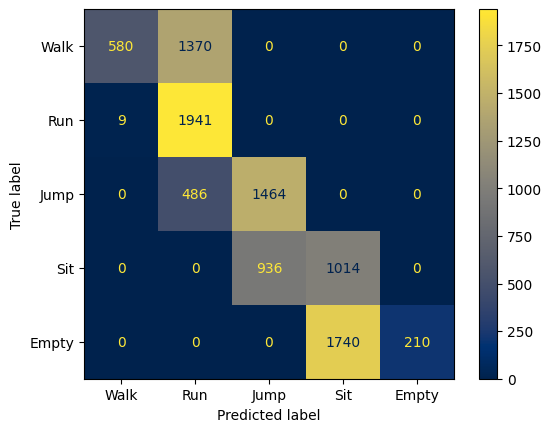

In [22]:
directory = './dumps/0_components'
filename = f'8lvls_single_antenna_{antenna}'
train_dump_dir=os.path.join(directory, f'training/{filename}.pkl')
test_dump_dir=os.path.join(directory, f'test/{filename}_test.pkl')
results = []


print("-------------- Training and testing DL model --------------")
X_train, y_train, y_train_dummy, scaler, fcolumns = load_experiment(train_dump_dir)
X_test, y_test, y_test_dummy, _, fcolumns = load_experiment(test_dump_dir, scaler)

name = "No-Fused-1"
run_edl_experiment(name, 0, 8, X_train, y_train_dummy)

# Test model
accuracy = results_test(0, 8, train_dump_dir, test_dump_dir)
results.append(
    {
        "num_components": 0,
        "num_levels": 8,
        "accuracy": accuracy
    })
        
results_df = pd.DataFrame(results)
os.makedirs('results_csv', exist_ok=True)
results_df.to_csv('results_csv/results2.csv', index=False)